## What to research now. 

Intresting to see how consistent the models internal rank is. As in dependent on the prompt how robust is the ranking of hotels. 

What to do: 
- Experiment with a variety of different prompts which as for the same thing
- Then compare the results
    - Hoe to compare: Relative frequency in each row. 

Thoughts:
- Differentiate between asking for different reccomemdatains (e.g Price or what is the most cost effective hotel.)
- Maybe try what is the most

Current prompt:
- "Reccommend five hotels in {city} UK. \n State the name of the hotel on a new line each time not using a numbered list."
- Use:
    - "Suggest five hotels in {city} UK. \n State the name of the hotel on a new line each time not using a numbered list."
    - ""Name five hotels in {city} UK. \n State the name of the hotel on a new line each time not using a numbered list."
    - Could you recommend five hotels in {city}, UK?
-   - Please recommend five hotels in {city}, UK.
    - Suggest five hotels in {city}, UK.
    - What are five hotels you would recommend in {city}, UK?
    - Can you list five hotels in {city}, UK?

What you need to make:
- Give city and generate the calls. 
- Then you should have your target words be the same for all. 
- As the whole process is so cheap you might as well just pickle all together. 

In [2]:
from methods import LMEO
lm = LMEO()

In [3]:
target_cities = ['Exeter', 'Bristol', 'London', 'Manchester', 'Newcastle', 'Brighton', 'Birmingham', 'Leeds', 'Liverpool']
target_prompts = [
    'Could you recommend five hotels in {}, UK? \n State the name of the hotel on a new line each time not using a numbered list.',
    'Please recommend five hotels in {}, UK. \n State the name of the hotel on a new line each time not using a numbered list.',
    'Suggest five hotels in {}, UK. \n State the name of the hotel on a new line each time not using a numbered list.',
    'What are five hotels you would recommend in {}, UK? \n State the name of the hotel on a new line each time not using a numbered list.',
    'Can you list five hotels in {}, UK? \n State the name of the hotel on a new line each time not using a numbered list.'
]

In [4]:
print(target_prompts[0].format(target_cities[0]))

Could you recommend five hotels in Exeter, UK? 
 State the name of the hotel on a new line each time not using a numbered list.


In [5]:
multi_city_results = lm.multiprompt_data(target_cities, target_prompts, 100)

KeyboardInterrupt: 

In [16]:
import pickle
with open(file=r"./pickles/multi_prompt_data_43.pkl", mode='rb') as file:
    multi_city_results = pickle.load(file)

In [7]:
Exeter_words =  [['Abode', 'ABode']] + 'Vin Mercure Holiday Queens Gate Devon Magdalen South Globe Rougemont Buckerel'.split()
Bristol_words =  ['Marriott','Gainsborough','Hilton','Mercure', 'arbour' ,'Radisson', 'Avon', 'DoubleTree', 'Berkeley', 'ibis', 'Future','ztec', 'gabel', ]
London_words = 'Savoy Langham Ritz Clarid hangri Dorchest Shard Rose Royal'.split()
Manchester_words = 'Gotham rincipal idland adisson ilton'.split() + ['Meli', 'inn', 'INN', 'Inn']
Newcastle_words = 'Crowne Vin County Dene Sandman Indigo Hilton Jury'.split()
Brighton_words = 'Drake Vin Jurys Artist Queens Grand TheBrighton'.split()
Birmingham_words = 'ACHotel adisson almaison BirminghamCityCentre Vin Cube dgbaston Grand Staying Indigo Hampton'.split()
Leeds_words = 'Dakota DoubleTree Malmaison Marrio Quebecs Radisson Queen Thorpe Park bisSt Cosmo'.split()
Liverpool_words = 'Double HopeS James Pullman Liner Titanic Indigo Richmond Malmaison'.split()

In [8]:
# from methods import Static
# for key, item in multi_city_results['Birmingham'].items():
#     Static.plot_from_ranks(item, Birmingham_words, 30)

## Findings:

-For London the results are very similar for each prompt. london liklkey has the most articles about hotels. This could suggest that the sureness in ranking scale with the amount of text on the articles. This woudl make a lot of sense. 

- Adittionaly for exeter, bristol, leeds there is greaer variation, this would support the above hypothesis. 

- Overall however the first choice does align with the list five hotels. This is intresting as just asking for a list it lists the products which it prefers the most. Hence it has a naming bias. 

## Testing Hypothesis. 

Want to see if thee is strong correlation with the population of a city and the consistency of the models. 


Need to devise a metric for the similarity. 
- In each
- Sum of the standard deviations of the ratio of each hotel above a certain level in each position. 

In [9]:
## Creating the metric. 
import numpy as np
from methods import LMEO, Static

def variation_metric(big_rank_dict, city_name, city_target_words):
    # Should you have a min? If the hotel doesnt appear then this should be taken into account
    
    #get the freq dict for each hotel, then make a new one which has the percentages.
    # should have a dict which has percent of evey hotel in every position at this point you shoudl use numpy 
    # vstack and then simply take the averavge. 

    lm = LMEO()

    all_percent_dict = {}

    for i, entire_rank in big_rank_dict[city_name].items():
        entire_rank = [rank for rank in entire_rank if len(rank) == 5]
        total = sum([len(rank) for rank in entire_rank])

        ith_freq_dict = lm.frequency_in_row(entire_rank, lm.group_hotels(entire_rank, city_target_words))
        # Now we will convert it to a percent:

        # We assume that there are 100 entries in each. 
        percent_dict = {}
        for level, all_frequencies in ith_freq_dict.items():
            freq = sum(all_frequencies.values())
            percent_dict[level] = {key: value/freq for key, value in all_frequencies.items()}
        
        all_percent_dict[i] = percent_dict

    # just will calculate the std in a lazy way not using numpy. 
    merged_dict = {} # for each level you should have a list of all percentages, 0 if not present
    
    for percent_dict in all_percent_dict.values():
        for level, hotels in percent_dict.items():
            if level not in merged_dict:
                merged_dict[level] = {}
            for hotel, freq in hotels.items():
                if hotel not in merged_dict[level]:
                    merged_dict[level][hotel] = []
                merged_dict[level][hotel].append(freq)

    return merged_dict
          


In [10]:
# Getting the average length of the hotel frequency.
from pprint import pprint 

test = variation_metric(multi_city_results, 'London', London_words)

for place, hotel_dict in test.items():
    print(place)
    mean_length = np.mean([len(list_of_freqs) for list_of_freqs in hotel_dict.values()])
    print('the mean is', mean_length)

for place, hotel_dict in test.items():
    print(place)
    std_lists = []
    
    for list_of_freqs in hotel_dict.values():
        if len(list_of_freqs) > 1:
            std_lists.append(np.std(list_of_freqs))

    print('the mean std of those lists with length greater than one is', np.mean(std_lists))

0
the mean is 2.6666666666666665
1
the mean is 2.736842105263158
2
the mean is 2.5517241379310347
3
the mean is 2.6666666666666665
4
the mean is 2.8620689655172415
0
the mean std of those lists with length greater than one is 0.02486388433224139
1
the mean std of those lists with length greater than one is 0.02793990127735378
2
the mean std of those lists with length greater than one is 0.022361766857868844
3
the mean std of those lists with length greater than one is 0.018079705972549705
4
the mean std of those lists with length greater than one is 0.01031146634487467


In [11]:
def comparison_metrics(multi_city_results, city_name, city_target_words):
    test = variation_metric(multi_city_results, city_name, city_target_words)

    mean_lengths = []
    std_means = []

    for place, hotel_dict in test.items():
        mean_length = np.mean([len(list_of_freqs) for list_of_freqs in hotel_dict.values()])
        mean_lengths.append(mean_length)

    for place, hotel_dict in test.items():
        std_lists = []
        for list_of_freqs in hotel_dict.values():
            if len(list_of_freqs) > 1:
                std_lists.append(np.std(list_of_freqs))
        if std_lists:
            std_means.append(np.mean(std_lists))

    mean_of_mean_lengths = np.mean(mean_lengths)
    mean_of_std_means = np.mean(std_means)

    print(city_name, mean_of_mean_lengths, mean_of_std_means)

In [12]:
# zipping together the cities and the words.
cities = [Exeter_words, Bristol_words, London_words, Manchester_words, Newcastle_words, Brighton_words, Birmingham_words, Leeds_words, Liverpool_words]
city_names = ['Exeter', 'Bristol', 'London', 'Manchester', 'Newcastle', 'Brighton', 'Birmingham', 'Leeds', 'Liverpool']
zipped = list(zip(city_names, cities))

for city_name, city_target_words in zipped:
    comparison_metrics(multi_city_results, city_name, city_target_words)

Exeter 2.888575737987503 0.018372439908179137
Bristol 2.7666450216450214 0.018676382309597856
London 2.6967937084089533 0.020711344956977677
Manchester 3.0825396825396827 0.020253676090776766
Newcastle 2.89986013986014 0.020632512540791167
Brighton 2.632617845117845 0.02019490576679061
Birmingham 2.7775 0.017346302938472204
Leeds 2.854329716566743 0.019723907913496118
Liverpool 2.6947512257857085 0.016922957415889783


In [13]:
pprint(test[3])

{'BlakesHotel': [0.008064516129032258],
 "Brown'sHotel": [0.008, 0.008620689655172414],
 'COMOMetropolitanLondon': [0.008264462809917356],
 'Clarid': [0.16129032258064516,
            0.18181818181818182,
            0.24,
            0.29310344827586204,
            0.18487394957983194],
 'CorinthiaHotelLondon': [0.016129032258064516, 0.016],
 'Dorchest': [0.07258064516129033,
              0.0743801652892562,
              0.104,
              0.07758620689655173,
              0.10084033613445378],
 'FourSeasonsHotelLondonatParkLane': [0.008064516129032258],
 'HamYardHotel': [0.008620689655172414],
 'Hotel': [0.008403361344537815],
 'InterContinentalLondonParkLane': [0.008264462809917356],
 'Langham': [0.11290322580645161,
             0.10743801652892562,
             0.12,
             0.0603448275862069,
             0.20168067226890757],
 'MandarinOrientalHydePark': [0.03225806451612903,
                              0.04132231404958678,
                              0.016,
    

In [25]:
pprint(multi_city_results['London'][0])

[['TheRitzLondon',
  'TheSavoyHotel',
  'MandarinOrientalHydePark',
  'TheNed',
  'TheDorchester'],
 ['TheRitzLondon', 'TheDorchester', 'LanghamHotel', 'TheSavoy', "Claridge's"],
 ['TheRitzLondon',
  'TheDorchester',
  'TheSavoy',
  "Claridge's",
  'Shangri-LaHotelattheShard'],
 ['TheRitzLondon',
  'TheDorchester',
  'TheLanghamLondon',
  'TheSavoy',
  'Shangri-LaHotelAtTheShardLondon'],
 ['TheRitzLondon',
  'TheDorchester',
  'Shangri-LaHotelatTheShard',
  'TheLanghamLondon',
  "Claridge's"],
 ['TheNed', "Claridge's", 'TheMandarinOriental', 'TheSavoy', 'TheDorchester'],
 ['TheRitzLondon', 'SohoHotel', 'TheLanghamLondon', 'TheNed', "Claridge's"],
 ['TheRitzLondon',
  'TheSavoy',
  "Claridge's",
  'TheLanghamLondon',
  'TheDorchester'],
 ['TheLanghamLondon', 'TheNed', 'TheSavoy', "Claridge's", 'TheRitzLondon'],
 ['TheRitzLondon',
  'TheLanghamLondon',
  'TheSavoy',
  'TheDorchester',
  "Claridge's"],
 ['TheRitzLondon',
  'TheDorchester',
  'TheLangham',
  'TheSavoy',
  'MandarinOriental

In [58]:
city_name = 'London'
city_target_words = London_words

i, j = 0, 4

def diff_ij(i, j, city_name, city_target_words):
    i_prompt_city_freq_dict = lm.frequency_in_row(multi_city_results[city_name][i], lm.group_hotels(multi_city_results[city_name][i], city_target_words))
    j_prompt_city_freq_dict = lm.frequency_in_row(multi_city_results[city_name][j], lm.group_hotels(multi_city_results[city_name][j], city_target_words))

    diff_dict = {key: {hotel: abs(i_prompt_city_freq_dict[key].get(hotel, 0) - j_prompt_city_freq_dict[key].get(hotel, 0)) for hotel in city_target_words} for key in i_prompt_city_freq_dict.keys()}
    average_diff = {key: np.mean(list(hotel_diff.values())) for key, hotel_diff in diff_dict.items()}
    
    return average_diff

# Now we will plot each of the 8 comboos


In [72]:
from matplotlib import pyplot as plt
import numpy as np

def plot_average_differences(city_name, city_target_words):
    def diff_ij(i, j, city_name, city_target_words):
        i_prompt_city_freq_dict = lm.frequency_in_row(multi_city_results[city_name][i], lm.group_hotels(multi_city_results[city_name][i], city_target_words))
        j_prompt_city_freq_dict = lm.frequency_in_row(multi_city_results[city_name][j], lm.group_hotels(multi_city_results[city_name][j], city_target_words))

        diff_dict = {key: {hotel: abs(i_prompt_city_freq_dict[key].get(hotel, 0) - j_prompt_city_freq_dict[key].get(hotel, 0)) for hotel in city_target_words} for key in i_prompt_city_freq_dict.keys()}
        average_diff = {key: np.mean(list(hotel_diff.values())) for key, hotel_diff in diff_dict.items()}

        return average_diff

    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    fig.suptitle(f'Average Differences for {city_name}')

    # Plot all combinations of i and j from 0 to 4
    for i in range(4):
        for j in range(i + 1, 5):
            average_diff = diff_ij(i, j, city_name, city_target_words)
            keys = list(average_diff.keys())
            values = list(average_diff.values())

            ax = axs[i, j-1]
            ax.plot(keys, values, label=f'Comparison {i},{j}')
            ax.axhline(np.mean(values), color='red', label='Mean')
            ax.set_ylim(0, 8)
            ax.set_xlabel('Keys')
            ax.set_ylabel('Average Difference')
            ax.set_title(f'Comparison {i},{j}')
            ax.tick_params(axis='x', rotation=45)
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

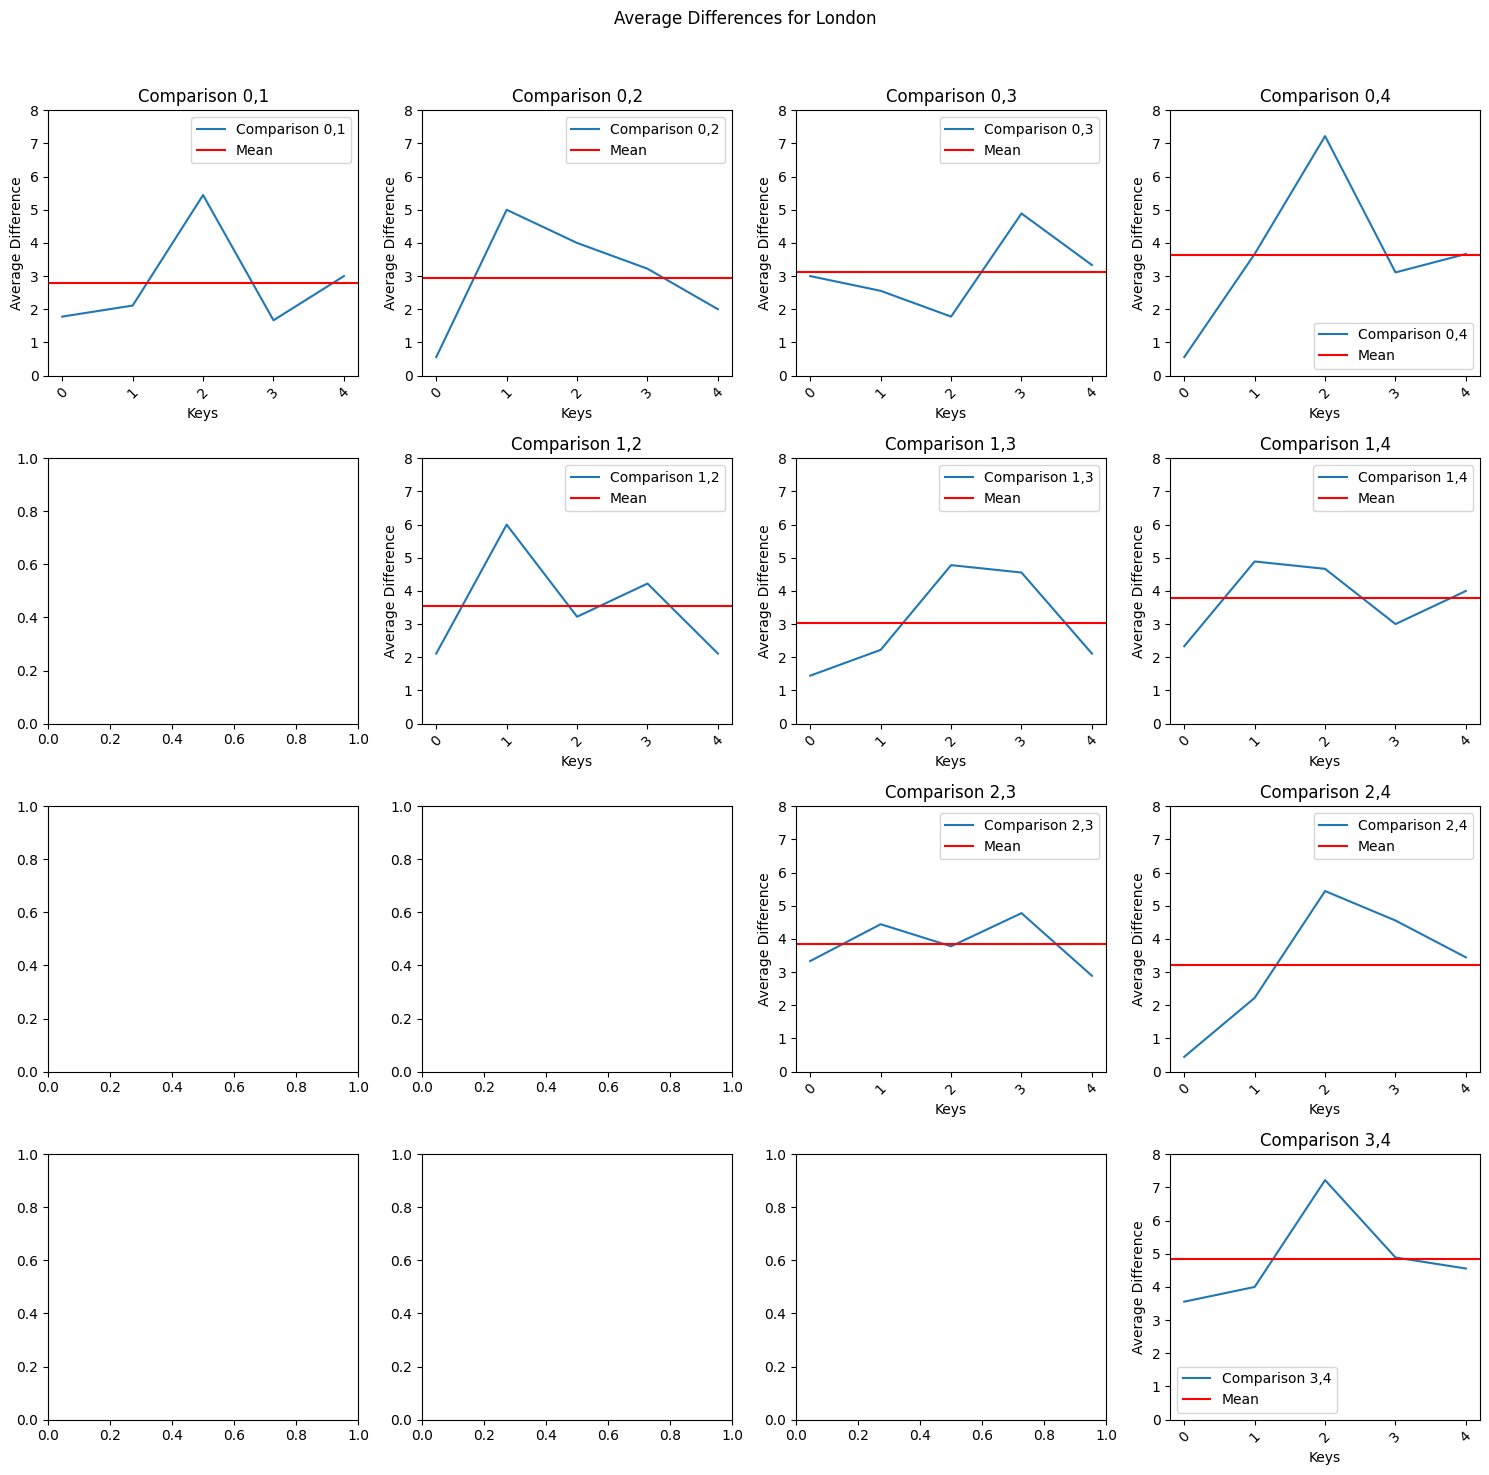

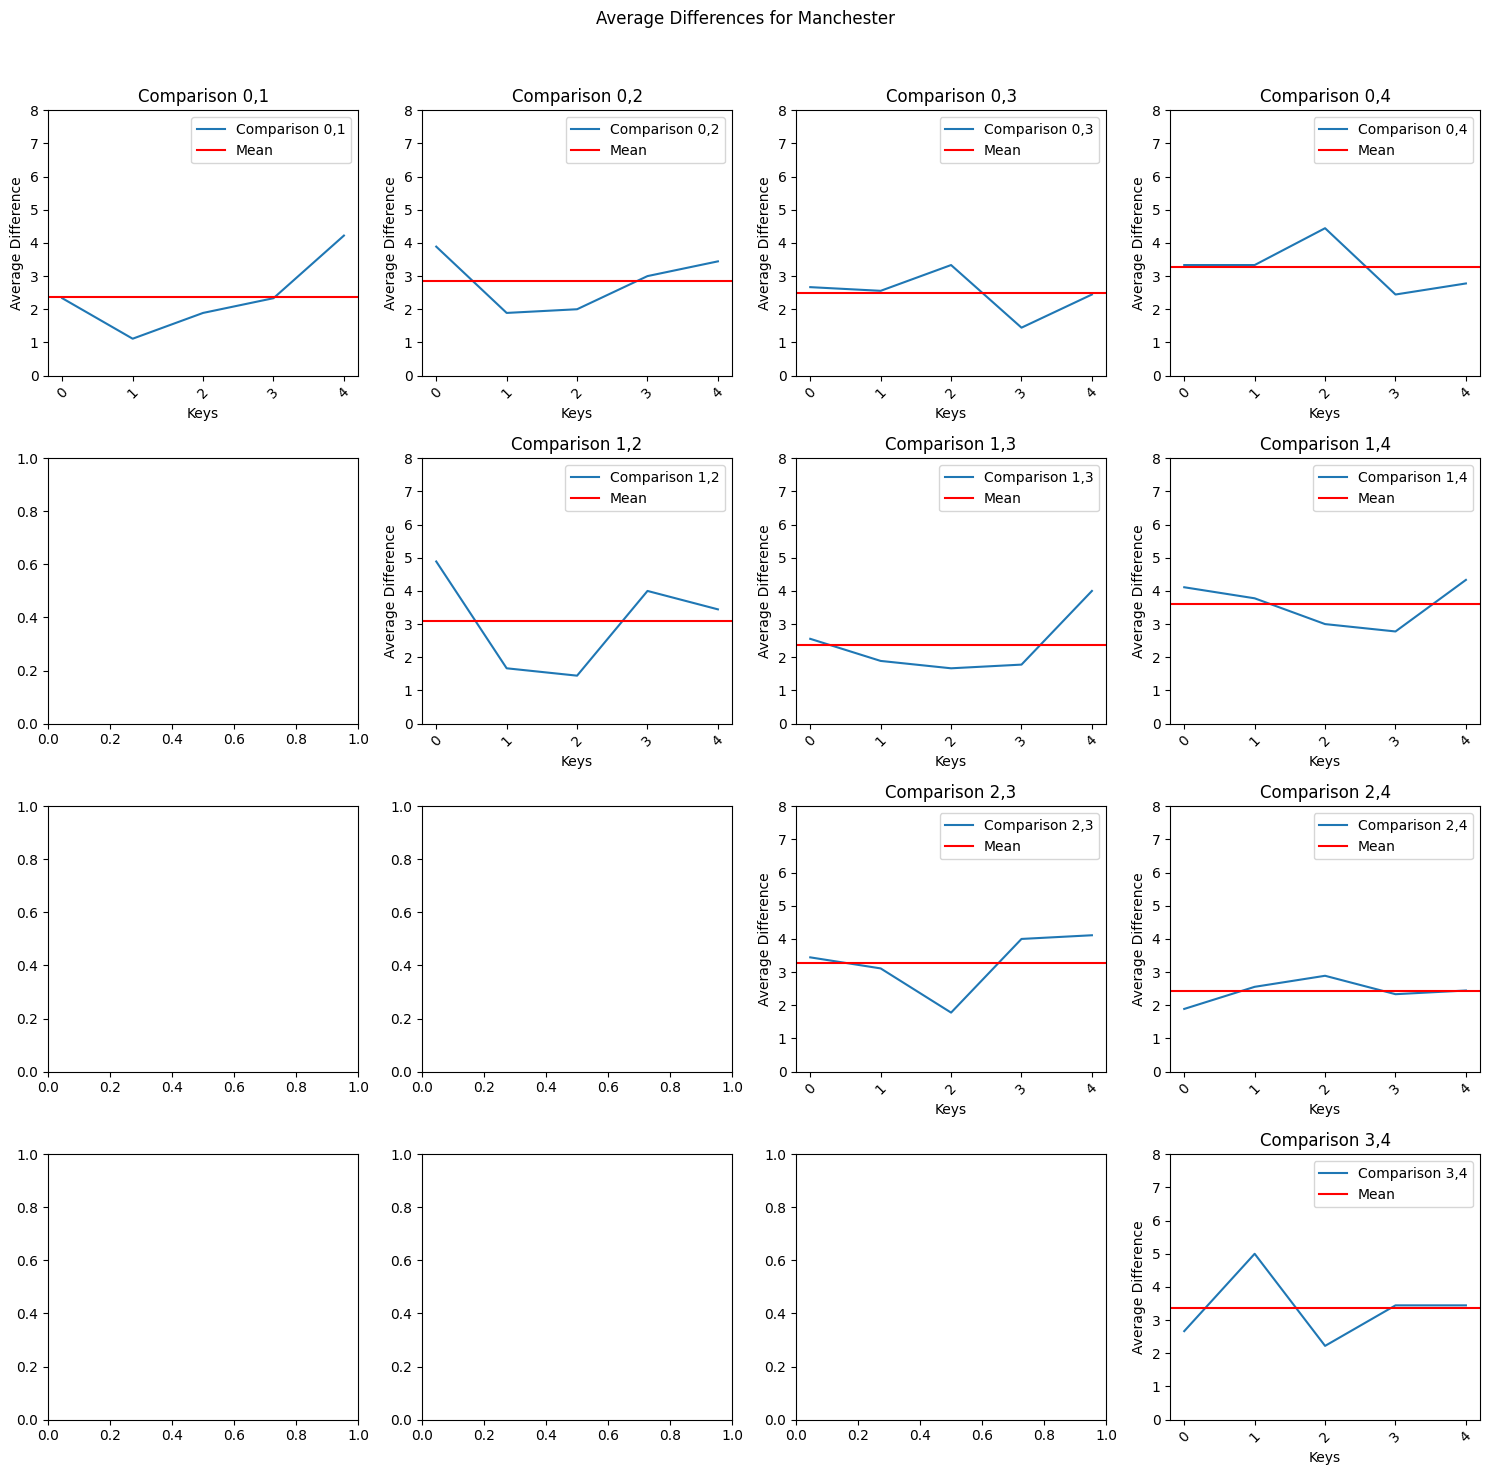

Newcastle
Brighton
Birmingham
Leeds


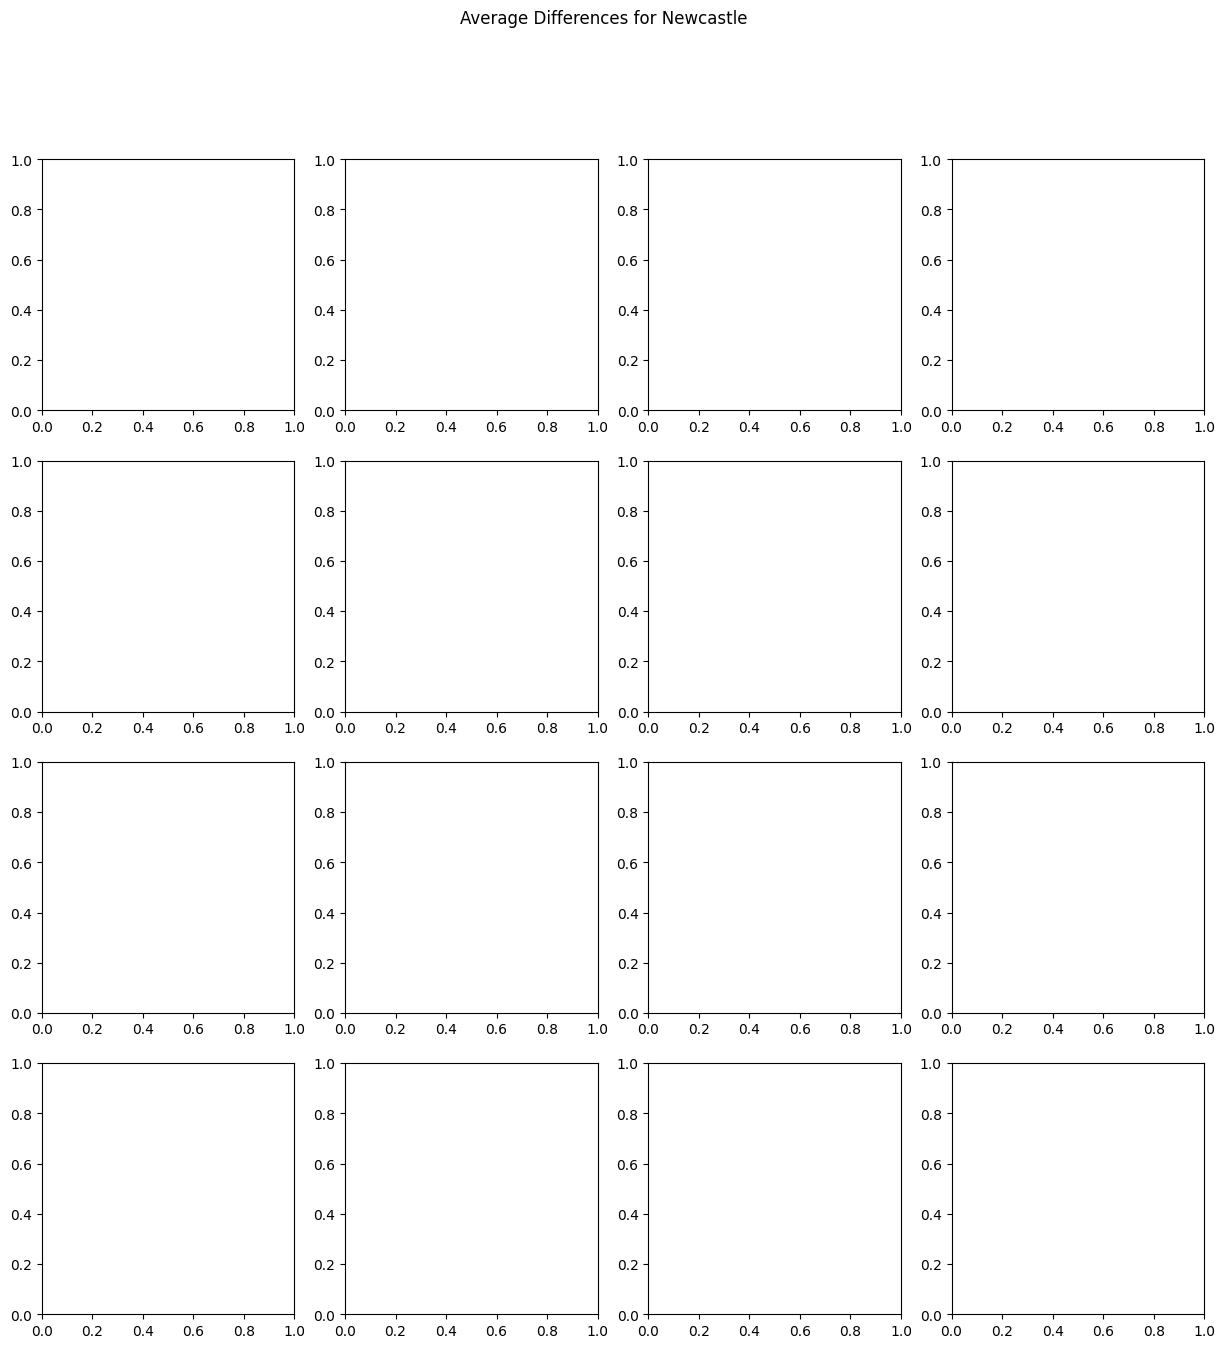

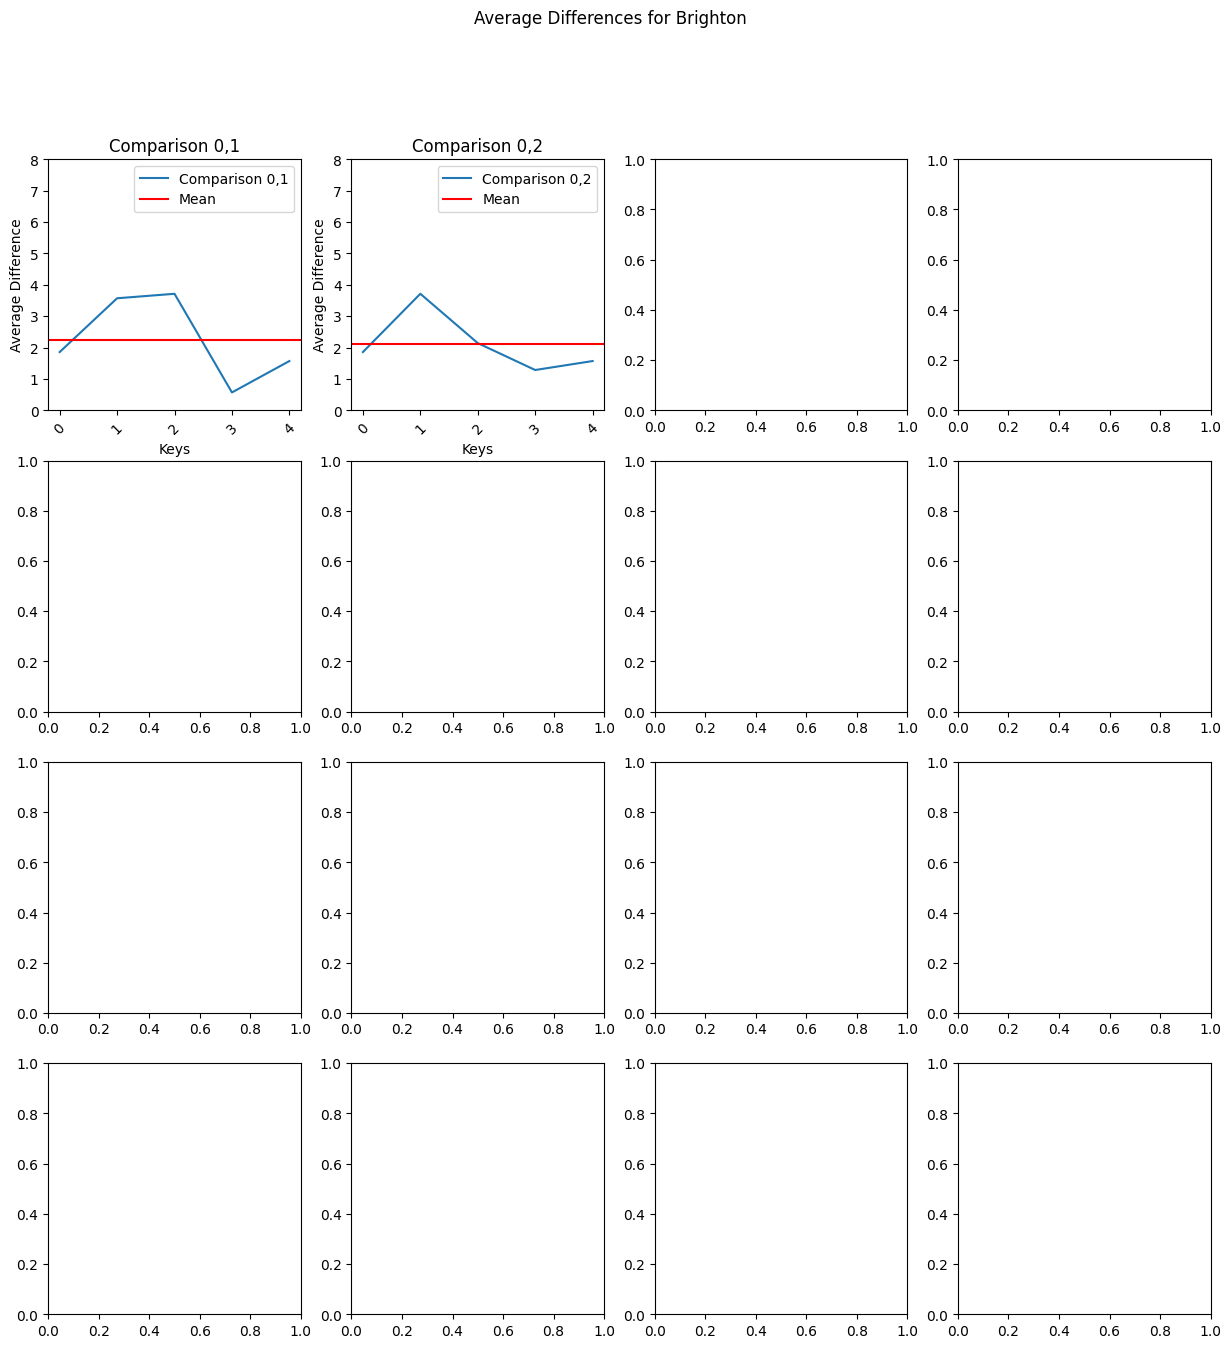

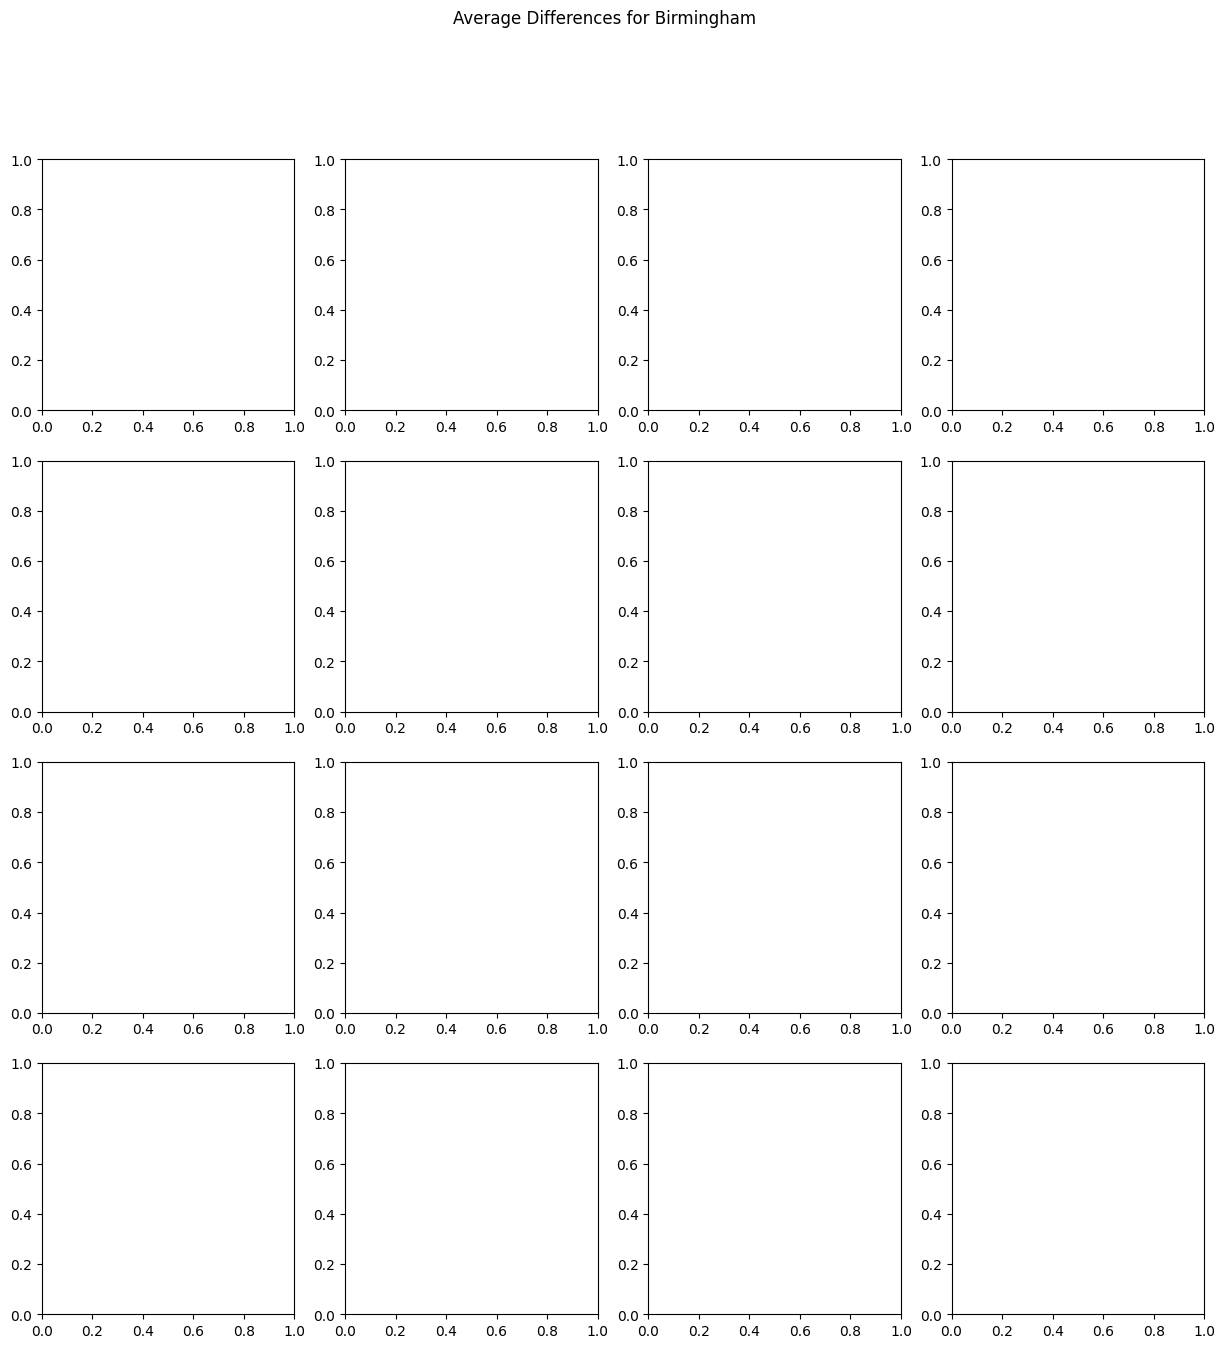

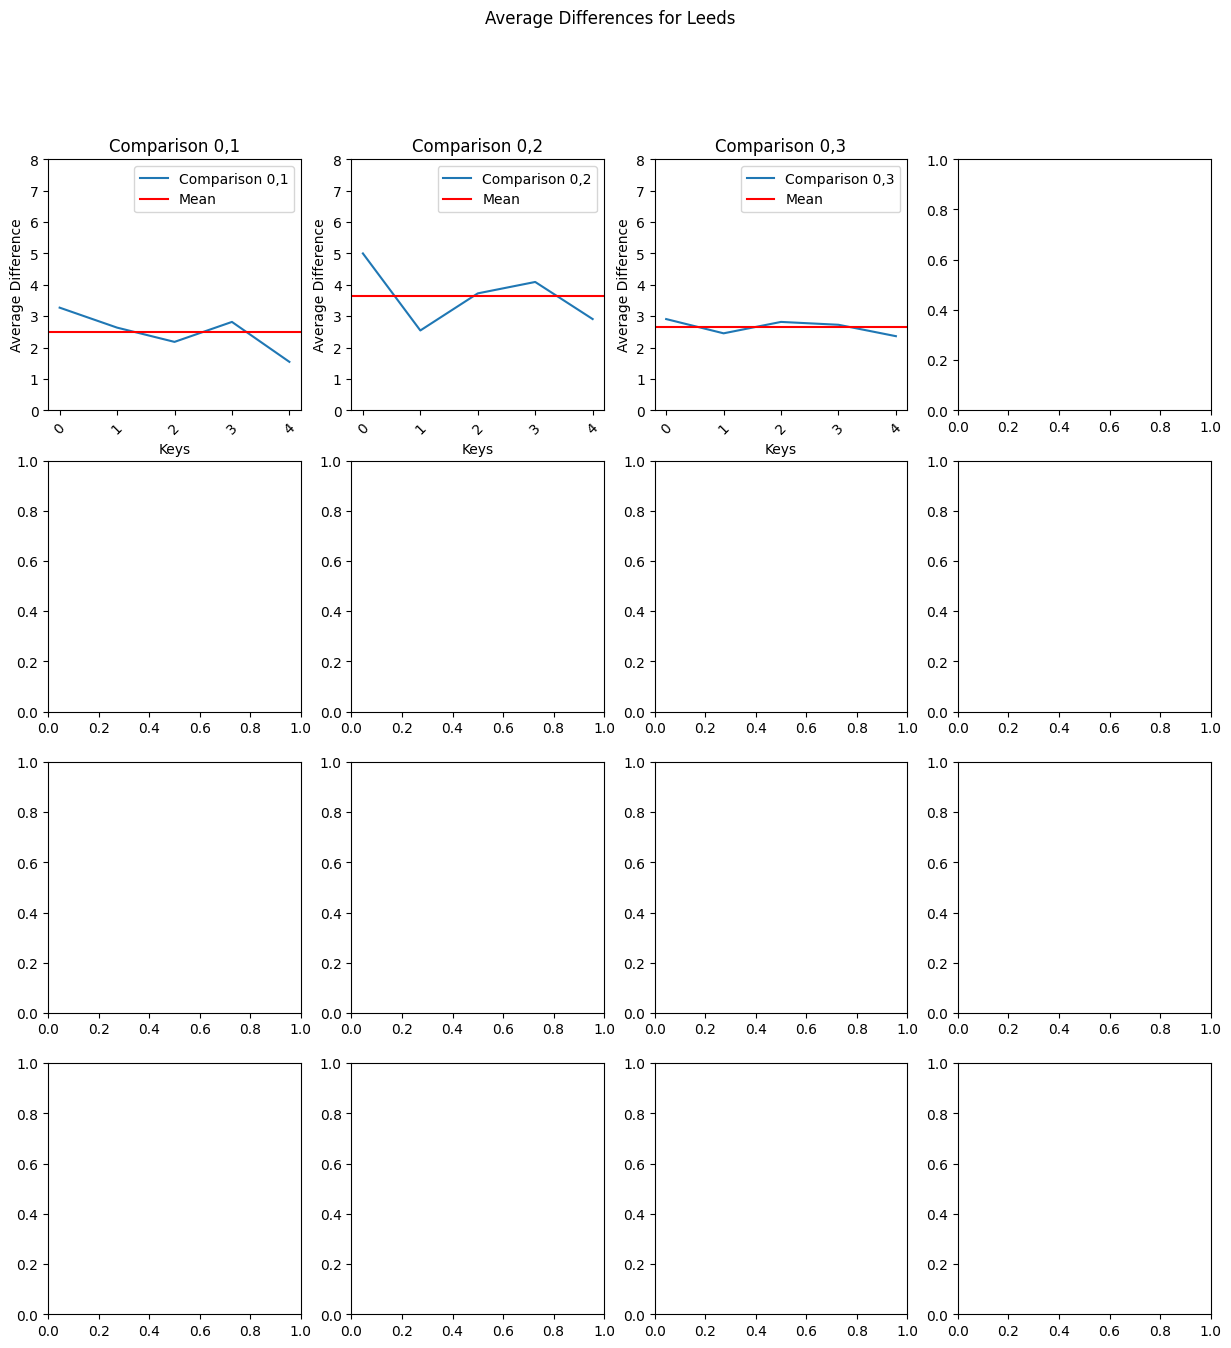

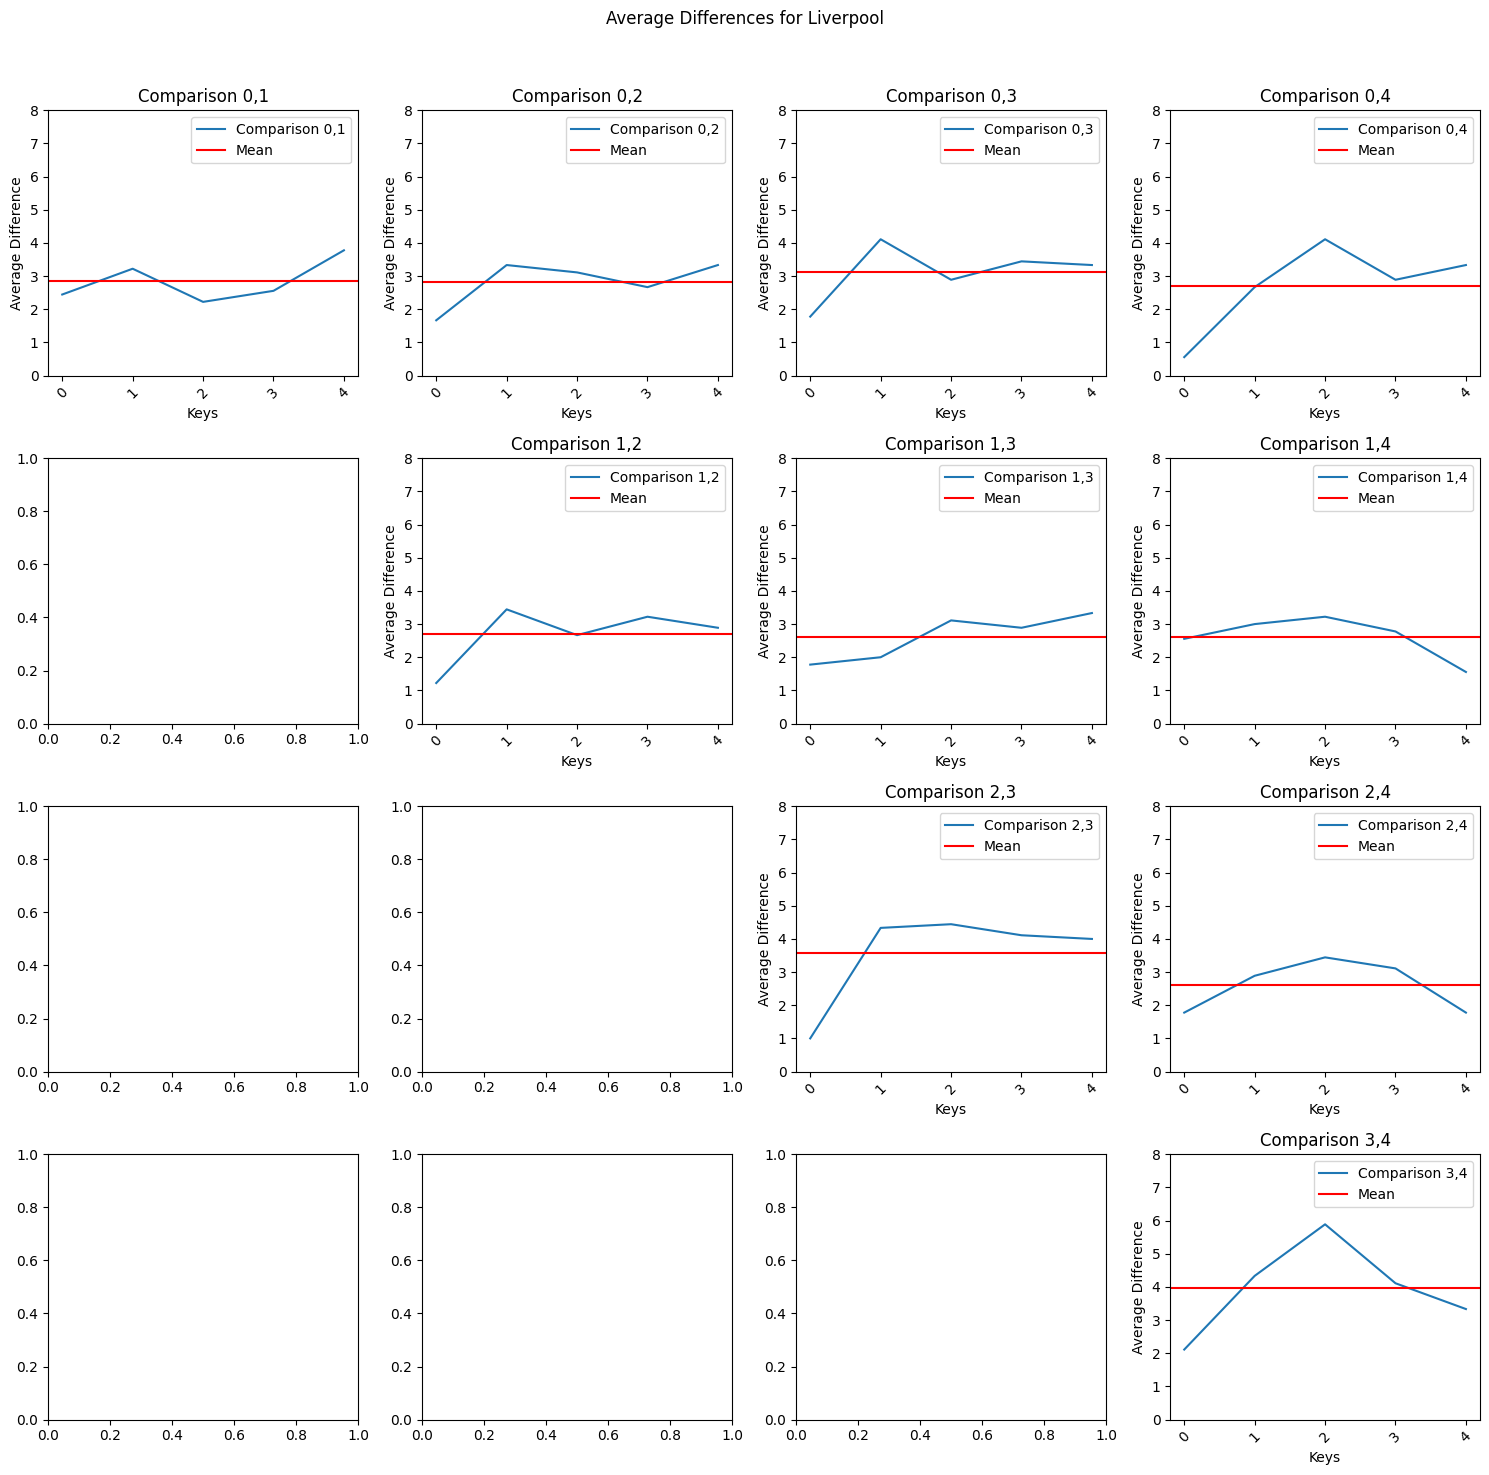

In [74]:
for city_name, city_target_words in zipped[2:]:
    try:
        plot_average_differences(city_name, city_target_words)
    except:
        print(city_name)

In [60]:
pprint(test)

{0: {'AceHotelShoreditch': [0.01],
     'Dorchest': [0.03, 0.04, 0.04, 0.04, 0.02],
     'Hotel': [0.01],
     'Langham': [0.04, 0.05, 0.02, 0.1, 0.03],
     'MandarinOrientalHydePark': [0.01],
     'MondrianLondon': [0.01],
     'Ritz': [0.85, 0.77, 0.87, 0.7, 0.88],
     'Savoy': [0.05, 0.11, 0.05, 0.1, 0.05],
     'StPancrasRenaissanceHotel': [0.01, 0.01],
     'TheConnaught': [0.01],
     'TheGrandatTrafalgarSquare': [0.01],
     'TheNed': [0.01, 0.01, 0.01, 0.05]},
 1: {'Clarid': [0.039603960396039604,
                0.01,
                0.019230769230769232,
                0.019801980198019802,
                0.01],
     'Dorchest': [0.1485148514851485,
                  0.15,
                  0.18269230769230768,
                  0.13861386138613863,
                  0.18],
     'FourSeasonsHotelLondonatParkLane': [0.009615384615384616],
     'GrandPlazaServicedApartments': [0.01],
     'HaymarketHotel': [0.009900990099009901],
     'Langham': [0.26732673267326734,
      

In [61]:
pprint(test[0]['Ritz'], test[1]['Ritz'])

AttributeError: 'list' object has no attribute 'write'